# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [12]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [13]:
data = pd.read_csv("baseCVs.csv")

In [14]:
data

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,hebrew,spanish
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,8,1,258,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,13,1,78,0,0,1,1,0,0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,64,1,175,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,10,0,0,0,0,1,0,0,0,0
642,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,7,1,431,0,0,1,0,0,0,0
643,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,47,1,12,0,0,0,0,0,0,0
644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Descriptivo de la base

In [15]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Education_Level_associate        646 non-null    float64
 1   Education_Level_bachelor         646 non-null    float64
 2   Education_Level_diploma          646 non-null    float64
 3   Education_Level_master           646 non-null    float64
 4   Education_Level_phd              646 non-null    float64
 5   Education_Level_unknown          646 non-null    float64
 6   Job_Title_architect              646 non-null    float64
 7   Job_Title_developer              646 non-null    float64
 8   Job_Title_engineer               646 non-null    float64
 9   Job_Title_manager                646 non-null    float64
 10  Job_Title_unknown                646 non-null    float64
 11  Total_Word_Count                 646 non-n

### División de la base en Train y Test

In [16]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (452, 38)
Forma de x_test: (194, 38)
Forma de y_train: (452,)
Forma de y: (194,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [18]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 900}
Precisión: 0.5309278350515464
Precisión: 0.3684210526315789
Recuperación: 0.1728395061728395
Puntuación F1: 0.23529411764705882
AUC ROC: 0.46864416038457335
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.57      0.79      0.66       113
           1       0.37      0.17      0.24        81

    accuracy                           0.53       194
   macro avg       0.47      0.48      0.45       194
weighted avg       0.49      0.53      0.48       194


Ranking de variables por importancia de Random Forest:
Keyword_Ratio                      0.120844
Professional_Profile_Word_Count    0.096456
Total_Word_Count                   0.091464
Work_Experience_Word_Count         0.086998
Keyword_Count                      0.083010
Skills_Word_Count                  0.079742
Education_Word_Count               0.075272
projects_Word_C

In [19]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
Has_Colors                         0.032323
Professional_Profile_Exists        0.031366
projects_Word_Count                0.026405
Projects_Exists                    0.026047
Education_Level_master             0.025739
Skills_Exists                      0.025363
Education_Level_diploma            0.023413
Achievements_Word_Count            0.021812
Keyword_Ratio                      0.019037
hebrew                             0.014371
Certifications_Exists              0.009661
Education_Level_bachelor           0.008946
Education_Level_unknown            0.007859
Education_Exists                   0.007817
Skills_Word_Count                  0.006327
french                             0.005808
Job_Title_unknown                  0.005443
Has_Photo                          0.002889
Education_Word_Count               0.000860
Education_Level_phd                0.000787
Job_Title_engineer                 0.000167
volunteer_work_Exists           

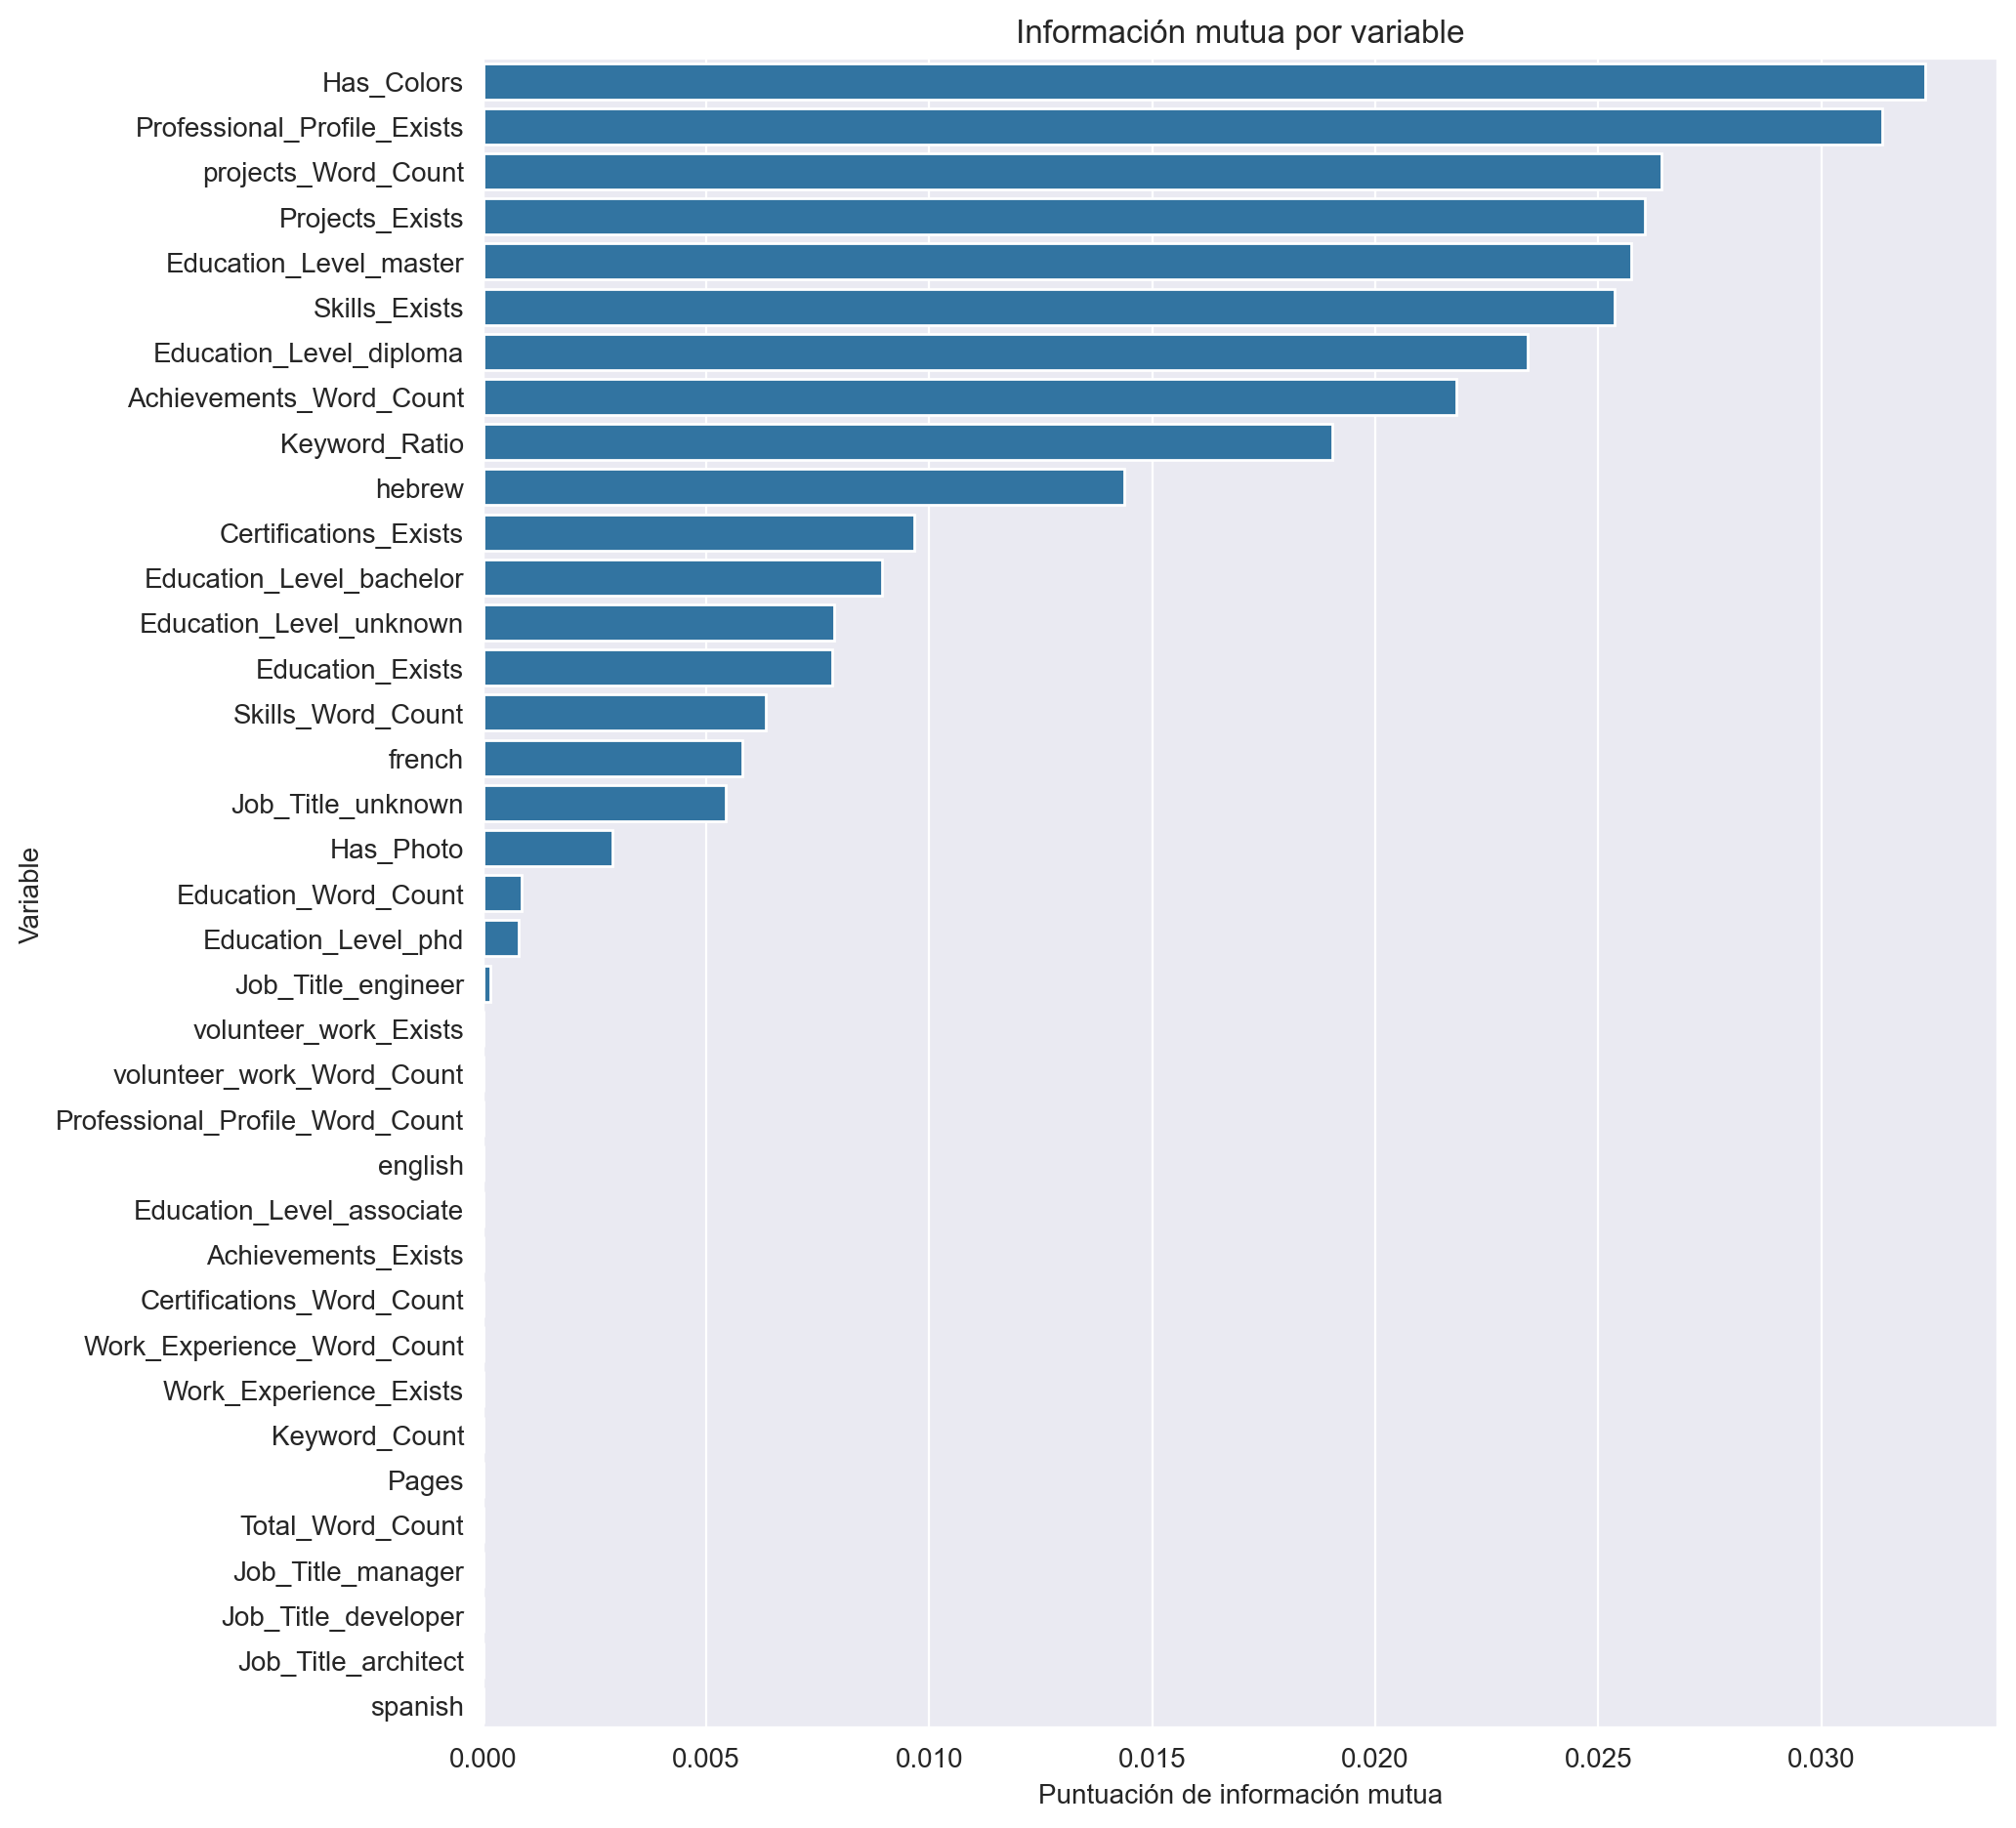

In [20]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [22]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Precisión: 0.4742268041237113
Precisión: 0.352112676056338
Recuperación: 0.30864197530864196
Puntuación F1: 0.32894736842105265
AUC ROC: 0.4380530973451327
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.54      0.59      0.57       113
           1       0.35      0.31      0.33        81

    accuracy                           0.47       194
   macro avg       0.45      0.45      0.45       194
weighted avg       0.46      0.47      0.47       194

Acierto en el conjunto de entrenamiento: 69.91(%)
Acierto en el conjunto de test: 47.42(%)
Variables seleccionadas: Index(['Education_Level_associate', 'Job_Title_developer', 'Job_Title_manager',
       'Has_Photo', 'Keyword_Count', 'Keyword_Ratio', 'volunteer_work_Exists',
       'volunteer_work_Word_Count', 'french', 'hebrew'],
      dtype='object')
Resultados para k=20:
Mejores hiperpar

## Agregar variables al modelo


In [23]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['volunteer_work_Exists', 'spanish', 'projects_Word_Count', 'Education_Level_associate', 'Education_Level_diploma', 'Certifications_Word_Count', 'Education_Level_bachelor', 'volunteer_work_Word_Count', 'french', 'Education_Level_phd', 'Job_Title_architect', 'Certifications_Exists', 'hebrew', 'Projects_Exists', 'Has_Photo', 'Education_Exists', 'Job_Title_unknown', 'Job_Title_manager', 'Work_Experience_Exists', 'Keyword_Count', 'Keyword_Ratio', 'Achievements_Exists', 'Education_Level_master', 'Education_Word_Count', 'Pages', 'Has_Colors', 'english', 'Job_Title_engineer', 'Total_Word_Count', 'Achievements_Word_Count', 'Education_Level_unknown', 'Job_Title_developer', 'Skills_Exists', 'Work_Experience_Word_Count', 'Skills_Word_Count', 'Professional_Profile_Word_Count', 'Professional_Profile_Exists']


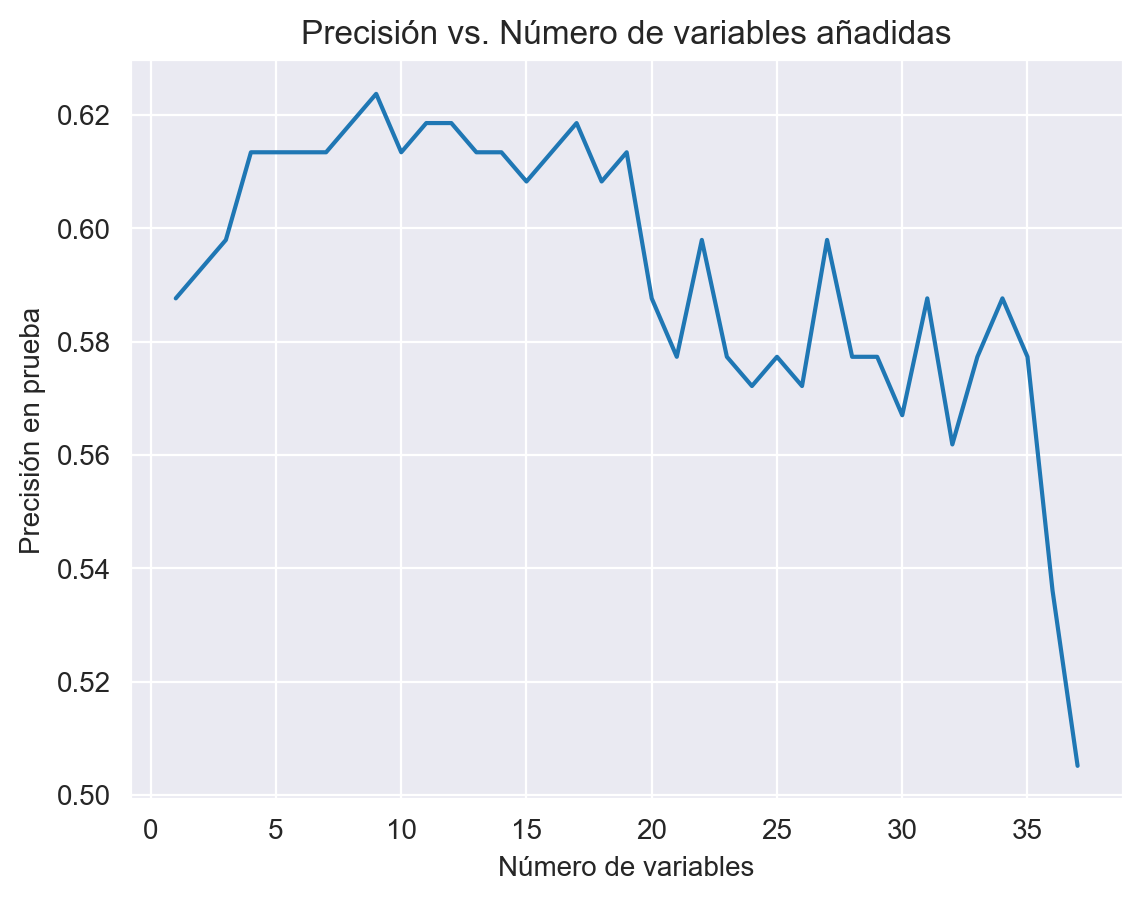

In [24]:
orden_vars, precisiones = agregar_variables_recursivamente(data)


Eliminar Variables del modelo

In [25]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Total_Word_Count', 'volunteer_work_Word_Count', 'Education_Level_bachelor', 'Education_Level_associate', 'hebrew', 'Job_Title_developer', 'Job_Title_architect', 'french', 'Achievements_Exists', 'Certifications_Exists', 'Education_Exists', 'Job_Title_unknown', 'Professional_Profile_Exists', 'Pages', 'projects_Word_Count', 'Skills_Exists', 'Projects_Exists', 'Has_Colors', 'Education_Level_unknown', 'Work_Experience_Exists', 'Keyword_Ratio', 'Has_Photo', 'Achievements_Word_Count', 'spanish', 'volunteer_work_Exists', 'Education_Level_master', 'Work_Experience_Word_Count', 'Certifications_Word_Count', 'Job_Title_manager', 'Professional_Profile_Word_Count', 'Skills_Word_Count', 'Education_Level_diploma', 'Keyword_Count', 'Education_Level_phd', 'Education_Word_Count', 'Job_Title_engineer']


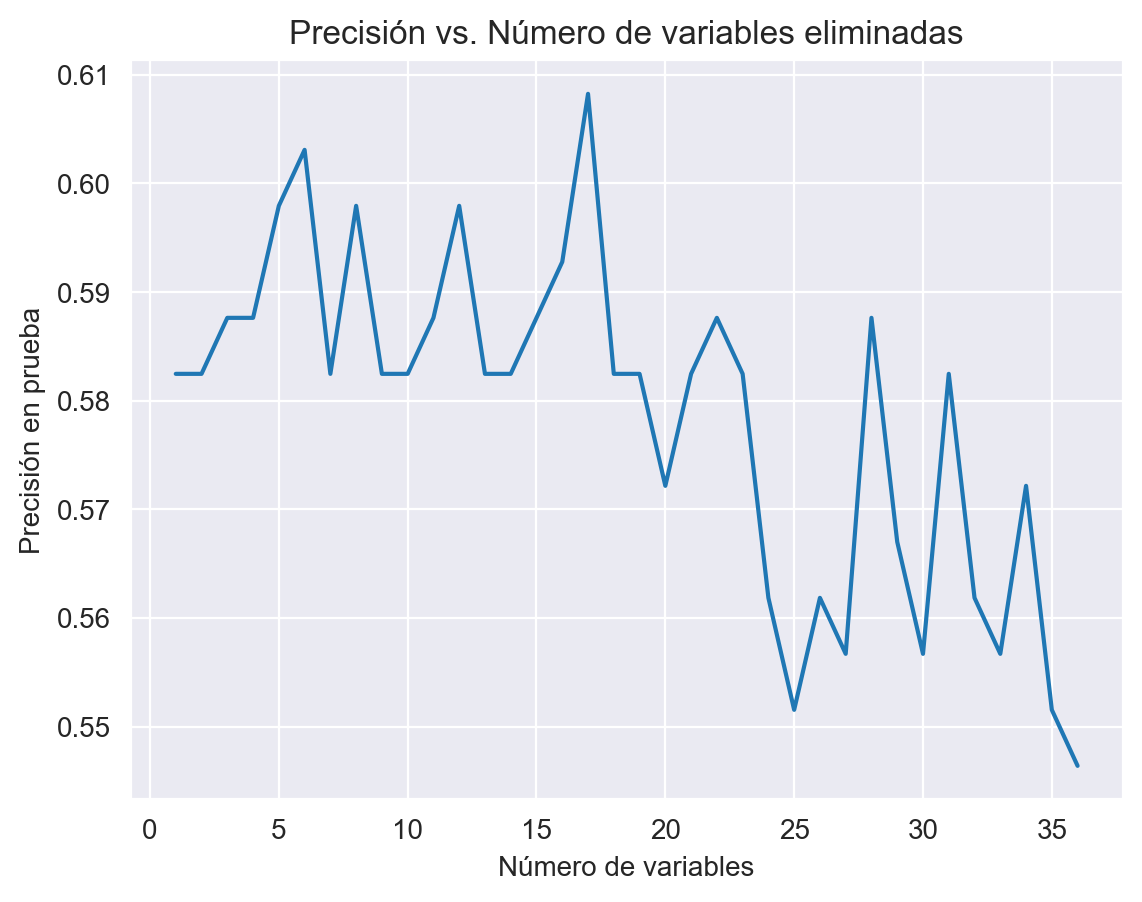

In [26]:
orden_vars, precisiones = eliminar_variables_recursivamente(data)

## Ranking de variables

In [27]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
Total_Word_Count                   0.105425
Keyword_Ratio                      0.104356
Work_Experience_Word_Count         0.092269
Keyword_Count                      0.091065
Education_Word_Count               0.078123
Skills_Word_Count                  0.076934
Professional_Profile_Word_Count    0.067114
projects_Word_Count                0.061681
Pages                              0.047127
english                            0.021043
Certifications_Word_Count          0.018853
Education_Level_unknown            0.017112
Has_Colors                         0.016536
Professional_Profile_Exists        0.016257
Has_Photo                          0.015919
Job_Title_developer                0.013960
Projects_Exists                    0.013538
Job_Title_engineer                 0.013380
Skills_Exists                      0.012838
Achievements_Word_Count            0.012682
Education_Level_master             0.012513
Education_Level_assoc

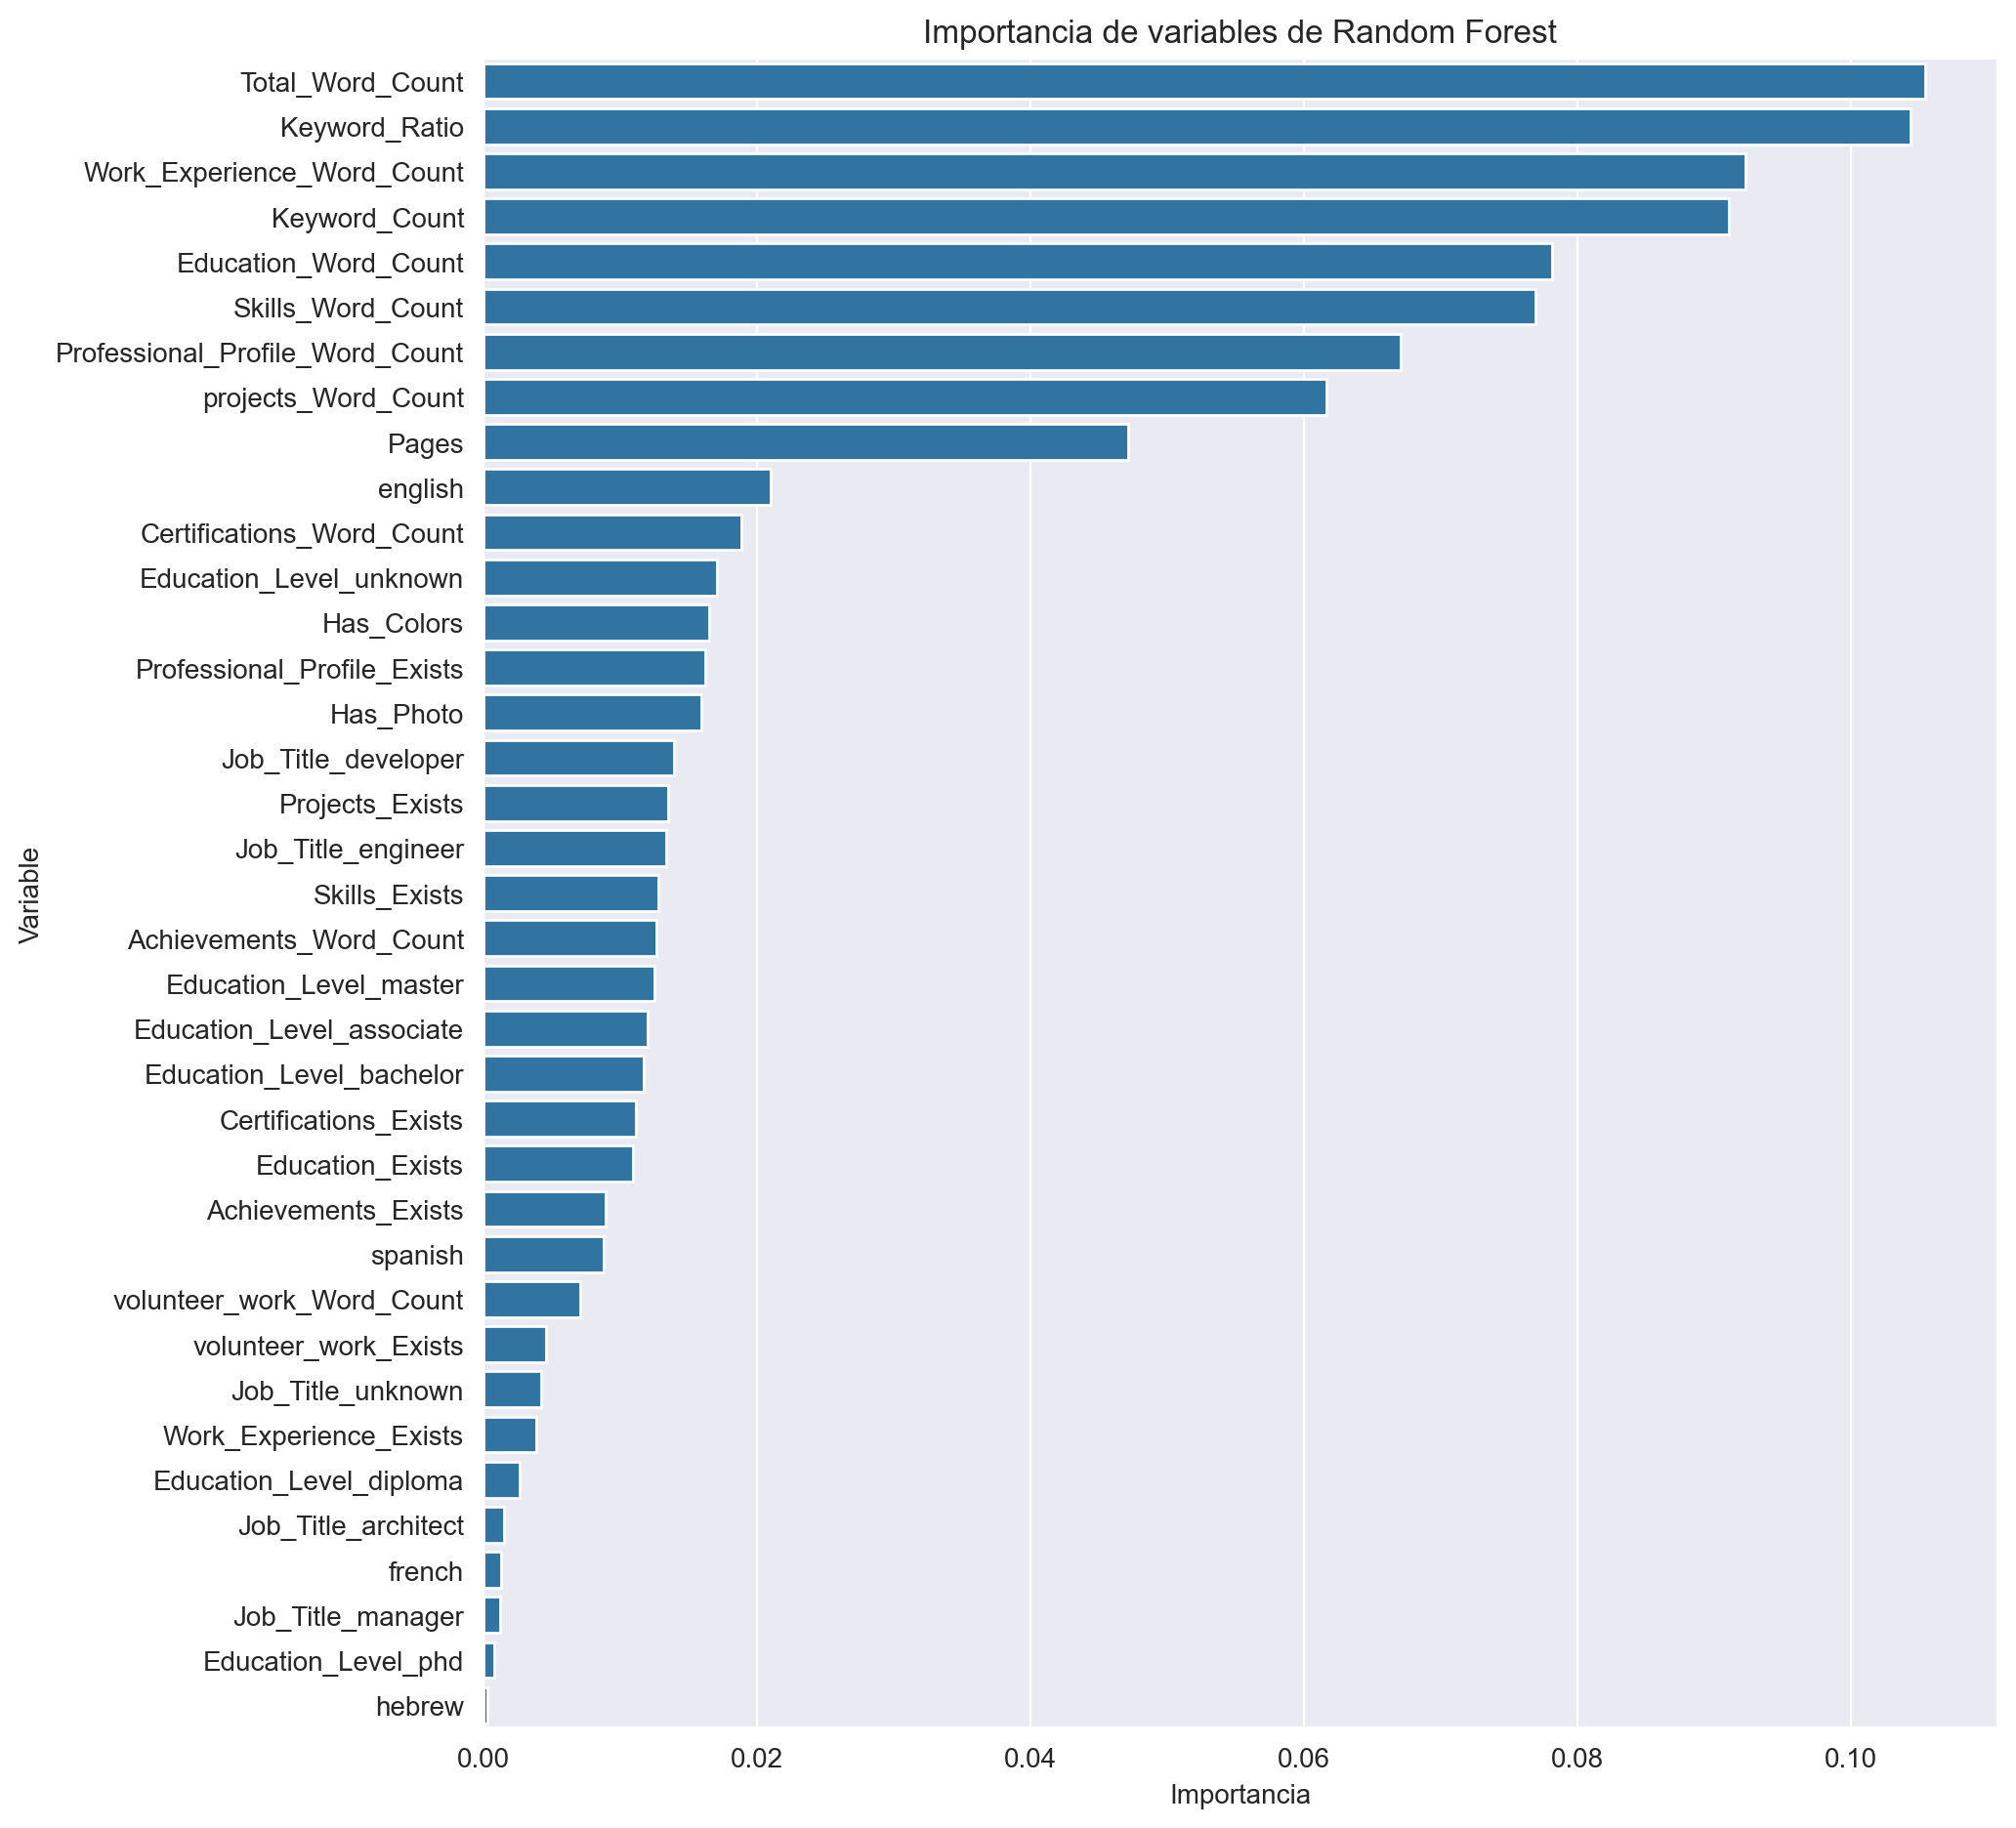

In [28]:
importancia_rf = obtener_importancia_rf(data)

# prueba con nuevo script ajustando muestra


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 📌 Step 1: Load the dataset
df = pd.read_csv("baseCVs.csv")

# 📌 Step 2: Define features & target variable
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

# 📌 Step 3: Remove low-importance features
low_importance_features = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count", "Has_Photo"]
X = X.drop(columns=low_importance_features)

# 📌 Step 4: Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Step 5: Handle Class Imbalance
# Choose between SMOTE (Oversampling) or Undersampling
use_smote = True  # Change to False to use undersampling instead

if use_smote:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_train, y_train = undersample.fit_resample(X_train, y_train)

# 📌 Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [500, 700, 1000],  # Number of trees
    "max_depth": [5, 10, 15],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 3, 5],  # Min samples per leaf
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Step 7: Train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 📌 Step 8: Evaluate the model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# 📌 Step 9: Print Metrics
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 10: Cross-Validation for Stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Step 11: Feature Importance Ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1000}
🔹 AUC-ROC Score: 0.4803849902534113

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57        76
           1       0.39      0.39      0.39        54

    accuracy                           0.49       130
   macro avg       0.48      0.48      0.48       130
weighted avg       0.49      0.49      0.49       130


🔹 Cross-Validation F1 Score: 0.575721505051866

🔹 Feature Importance:
 Keyword_Ratio                      0.097511
Total_Word_Count                   0.093267
Education_Word_Count               0.082628
Professional_Profile_Word_Count    0.075903
Job_Title_engineer                 0.072442
Keyword_Count                      0.068058
Skills_Word_Count                  0.063070
Work_Experience_Word_Count         0.061670
Job_Title_developer                0.058026
projects_Word_Count            

### El modelo no funcionó bien con random forest, necesita ajuste.

Intentaremos con xGBoost

In [30]:
import xgboost as xgb
from imblearn.combine import SMOTEENN

# Remove non-numeric columns
if "CV_Name" in df.columns:
    df = df.drop(columns=["CV_Name"])

if "CV_Type" in df.columns:
    df = df.drop(columns=["CV_Type"])

# 📌 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Apply SMOTEENN to balance classes
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# 📌 Train Optimized XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=700,  # More trees for stability
    max_depth=4,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate improves generalization
    subsample=0.6,  # Prevent overfitting
    colsample_bytree=0.8,  # Keep feature diversity
    min_child_weight=3,  # Prevents small splits
    scale_pos_weight=4,  # Adjust class balance
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Evaluate model
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Cross-validation for stability
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 AUC-ROC Score: 0.43116471734892786

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.25      0.32        76
           1       0.36      0.59      0.45        54

    accuracy                           0.39       130
   macro avg       0.41      0.42      0.39       130
weighted avg       0.42      0.39      0.38       130


🔹 Cross-Validation F1 Score: 0.7887659689216975

🔹 Feature Importance:
 Work_Experience_Exists             0.081114
Education_Level_master             0.073140
Education_Level_bachelor           0.065526
Professional_Profile_Word_Count    0.060708
Total_Word_Count                   0.053400
Job_Title_engineer                 0.053374
Certifications_Word_Count          0.052168
Job_Title_developer                0.048567
projects_Word_Count                0.048425
Keyword_Count                      0.048087
Work_Experience_Word_Count         0.047959
Education_Exists                   0.043745
Educati